# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [10]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
regularization_strengths = [1e1, 1e2, 1e3, 1e-1, 1e-2, 1e-3, 5e-1, 7e-3, 2e-2, 5e-2, 5e-3, 1e-4]


results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
lr_rs = [ (lr,rs) for lr in learning_rates for rs in regularization_strengths ]

for lr, rs in lr_rs:
    # Create a new SVM instance
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train_feats)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val_feats)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Print results
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    # Save results
    results[(lr,rs)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm 
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-01 reg 1.000000e+01 train accuracy: 0.022857 val accuracy: 0.021000
lr 1.000000e-01 reg 1.000000e+02 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e+03 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e-01 train accuracy: 0.457082 val accuracy: 0.433000
lr 1.000000e-01 reg 1.000000e-02 train accuracy: 0.477082 val accuracy: 0.453000
lr 1.000000e-01 reg 1.000000e-03 train accuracy: 0.483449 val accuracy: 0.466000
lr 1.000000e-01 reg 5.000000e-01 train accuracy: 0.428755 val accuracy: 0.405000
lr 1.000000e-01 reg 7.000000e-03 train accuracy: 0.486980 val accuracy: 0.480000
lr 1.000000e-01 reg 2.000000e-02 train accuracy: 0.482388 val accuracy: 0.487000
lr 1.000000e-01 reg 5.000000e-02 train accuracy: 0.474816 val accuracy: 0.454000
lr 1.000000e-01 reg 5.000000e-03 train accuracy: 0.480837 val accuracy: 0.477000
lr 1.000000e-01 reg 1.000000e-04 train accuracy: 0.487082 val accuracy: 0.485000
lr 1.000000e-02 reg 1.000000

In [11]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.476


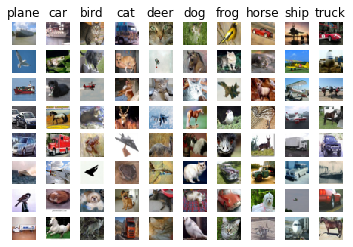

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [13]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [19]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
#hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# Use of random search for hyperparameter search
for i in range(30):
    lr, reg, hd = generate_random_hyperparams(-1, 1, -7, -4, 10, 500)
    # Create a two-layer network
    net = TwoLayerNet(input_dim, hd, num_classes)
    
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train_feats) == y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_val_feats) == y_val).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hd, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 2.466976e-01 reg 1.169136e-06 hid 47  train accuracy: 0.610204 val accuracy: 0.564000
lr 9.740826e-01 reg 5.524623e-05 hid 147  train accuracy: 0.714286 val accuracy: 0.554000
lr 3.407913e-01 reg 7.361108e-07 hid 318  train accuracy: 0.724551 val accuracy: 0.586000
lr 3.461224e-01 reg 8.607588e-07 hid 298  train accuracy: 0.719612 val accuracy: 0.581000
lr 2.185714e+00 reg 1.391955e-06 hid 285  train accuracy: 0.777898 val accuracy: 0.546000
lr 6.789704e-01 reg 3.127064e-07 hid 253  train accuracy: 0.766551 val accuracy: 0.594000
lr 3.014389e+00 reg 1.444320e-06 hid 194  train accuracy: 0.701980 val accuracy: 0.531000
lr 1.234229e+00 reg 7.070268e-07 hid 146  train accuracy: 0.712878 val accuracy: 0.564000
lr 1.178204e+00 reg 1.124069e-07 hid 136  train accuracy: 0.706776 val accuracy: 0.564000


/Users/admin/Downloads/assignment1-2/cs231n/classifiers/neural_net.py:101: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax_matrix[np.arange(N), y]))


lr 4.055651e+00 reg 6.169076e-07 hid 132  train accuracy: 0.139612 val accuracy: 0.119000
lr 1.271965e-01 reg 1.263811e-05 hid 17  train accuracy: 0.548286 val accuracy: 0.534000


/Users/admin/Downloads/assignment1-2/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W2 * W2) + np.sum(W1 * W1))#regularization
/Users/admin/Downloads/assignment1-2/cs231n/classifiers/neural_net.py:97: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True) #make numbers smaller
/Users/admin/Downloads/assignment1-2/cs231n/classifiers/neural_net.py:97: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True) #make numbers smaller
/Users/admin/Downloads/assignment1-2/cs231n/classifiers/neural_net.py:124: RuntimeWarning: invalid value encountered in greater
  dfc1 = dW1 * (fc1>0)             # [NxH].[NxH] = [NxH]


lr 6.433745e+00 reg 8.668252e-07 hid 84  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.545769e+00 reg 6.939348e-07 hid 402  train accuracy: 0.100265 val accuracy: 0.087000
lr 5.892035e-01 reg 6.173118e-07 hid 125  train accuracy: 0.695204 val accuracy: 0.552000
lr 1.377532e-01 reg 2.655388e-05 hid 476  train accuracy: 0.626000 val accuracy: 0.573000
lr 4.281388e-01 reg 6.155762e-05 hid 256  train accuracy: 0.737837 val accuracy: 0.586000
lr 3.833183e-01 reg 4.463186e-07 hid 55  train accuracy: 0.629000 val accuracy: 0.566000
lr 2.977404e-01 reg 1.162264e-05 hid 344  train accuracy: 0.715612 val accuracy: 0.591000


/Users/admin/Downloads/assignment1-2/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in multiply
  loss += reg * (np.sum(W2 * W2) + np.sum(W1 * W1))#regularization


lr 5.669717e+00 reg 4.219898e-06 hid 394  train accuracy: 0.100265 val accuracy: 0.087000
lr 5.765840e+00 reg 1.347369e-07 hid 74  train accuracy: 0.100265 val accuracy: 0.087000
lr 3.992030e-01 reg 3.679460e-05 hid 487  train accuracy: 0.760143 val accuracy: 0.603000
lr 9.480570e-01 reg 4.664651e-07 hid 135  train accuracy: 0.707653 val accuracy: 0.566000
lr 1.128440e+00 reg 6.899338e-06 hid 417  train accuracy: 0.834857 val accuracy: 0.557000
lr 1.822665e-01 reg 2.469961e-07 hid 92  train accuracy: 0.626755 val accuracy: 0.569000
lr 2.555753e-01 reg 5.003782e-07 hid 252  train accuracy: 0.689224 val accuracy: 0.608000
lr 1.948539e-01 reg 5.064054e-07 hid 487  train accuracy: 0.669980 val accuracy: 0.595000
lr 9.165297e+00 reg 1.395258e-06 hid 399  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.825165e+00 reg 3.446074e-06 hid 11  train accuracy: 0.511918 val accuracy: 0.497000
lr 1.267451e+00 reg 2.468592e-07 hid 399  train accuracy: 0.826224 val accuracy: 0.559000
lr 2.952598e-

In [20]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.562
